In [5]:
import os
import gzip
import json
import pandas as pd
import collections
import datasets
import matplotlib.pyplot as plt
datasets.logging.set_verbosity_error()
from datasets import load_dataset
from tqdm import tqdm
tqdm.pandas()

In [6]:
# Define a “pretty print” function pprint for dict objects and dataframes.
pprint = lambda x: print(json.dumps(x, indent=2)) if isinstance(x, dict) else display(x)

# Loading Data

In [7]:
reviews = []
items = []

In [8]:
file = "data/Software.jsonl.gz"

with gzip.open(file, 'rt') as fp:
    for line in fp:
        reviews.append(json.loads(line.strip()))


In [9]:
file = "data/meta_Software.jsonl.gz"

with gzip.open(file, 'rt') as fp:
    for line in fp:
        items.append(json.loads(line.strip()))

In [10]:
reviews_df = pd.read_json("data/Software.jsonl.gz", lines=True, compression='gzip')

In [11]:
items_df = pd.read_json("data/meta_Software.jsonl.gz", lines=True, compression='gzip')

# Exploratory Data Analysis

### Goal: Predict whether a user has bought an item

In [12]:
reviews_df.head()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True


In [13]:
items_df.head()


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Appstore for Android,Accupressure Guide,3.6,NaN,[All the pressing point has been explained wit...,[Acupressure technique is very ancient and ver...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",mAppsguru,[],"{'Release Date': '2015', 'Date first listed on...",B00VRPSGEO,NaN,NaN,NaN
1,Appstore for Android,Ankylosaurus Fights Back - Smithsonian's Prehi...,4.0,NaN,[ENCOURAGE literacy skills with highlighted na...,[Join Ankylosaurus in this interactive book ap...,2.99,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]","Oceanhouse Media, Inc",[],"{'Release Date': '2014', 'Date first listed on...",B00NWQXXHQ,NaN,NaN,NaN
2,Appstore for Android,Mahjong 2015,3.1,NaN,[Mahjong 2015 is a free solitaire matching gam...,[Mahjong 2015 is a free solitaire matching gam...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",sophiathach,[],"{'Release Date': '2014', 'Date first listed on...",B00RFKP6AC,NaN,NaN,NaN
3,Appstore for Android,Jewels Brick Breakout,4.2,NaN,"[Game Features:, - Intuitive touch controls wi...",[Jewels Brick Breakout is a glowing jewels bri...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Bad Chicken,[],"{'Release Date': '2015', 'Date first listed on...",B00SP2QU0E,NaN,NaN,NaN
4,Appstore for Android,Traffic Police: Off-Road Cub,3.3,NaN,"[In this game you will find:, - Killer police ...",[Become the best road police officer in Cube C...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Dast 2 For Metro,[],"{'Release Date': '2016', 'Date first listed on...",B01DZIT64O,NaN,NaN,NaN


In [14]:
Number_unique_bought = reviews_df['parent_asin'].nunique()
Number_all_items = items_df['parent_asin'].nunique()
print(f'number of unique items bought: {Number_unique_bought}')
print(f'number of all items: {Number_all_items}')
print(f'percentage of items bought: {Number_unique_bought/Number_all_items*100}%')

number of unique items bought: 89246
number of all items: 89251
percentage of items bought: 99.99439782187315%


### Let's find how much reviews each product has

In [15]:
number_reviews = reviews_df.groupby('parent_asin')['text'].count().sort_values(ascending=False)
display(number_reviews)
average_reviews = number_reviews.mean()
print(f'average number of reviews per item: {average_reviews}')

parent_asin
B00FAPF5U0    50891
B00N28818A    46940
B00992CF6W    44324
B005ZXWMUS    33079
B0094BB4TW    30212
              ...  
B00GNDN98I        1
B01M6BS9GL        1
B00GNFUXD0        1
B00GNG2GMA        1
b017poz7y2        1
Name: text, Length: 89246, dtype: int64

average number of reviews per item: 54.68234990923963


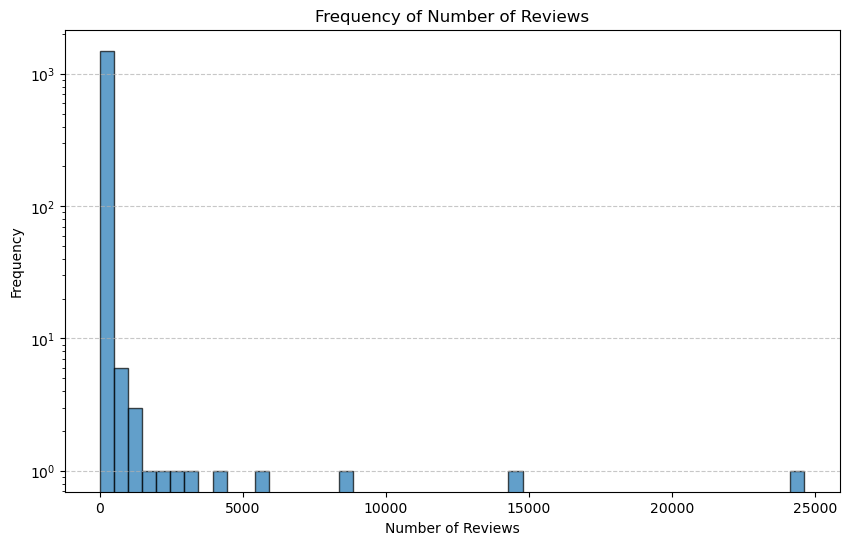

In [17]:
review_counts = number_reviews.reset_index()['text'].value_counts()

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(review_counts, bins=50, edgecolor='k', alpha=0.7)
plt.title('Frequency of Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.yscale('log')  # Use a logarithmic scale if there's a large disparity in counts
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Let's find out how much users exist in the reviews dataset

In [18]:
Number_users = reviews_df['user_id'].nunique()
print(f'number of unique users: {Number_users}')
average_reviews_per_user = reviews_df.groupby('user_id')['text'].count().mean()
print(f'average number of reviews per user: {average_reviews_per_user}')

number of unique users: 2589466
average number of reviews per user: 1.8846283364987222


note: not all reviews are verified purchases however, let's find the number of verified purchases and compare it to overall reviews

In [19]:
verified_purchase=reviews_df['verified_purchase'].sum()
all_reviews = len(reviews_df)
print(f'Number of verified purchases: {verified_purchase}')
print(f'Percentage of verified purchases: {verified_purchase/all_reviews*100}%')

Number of verified purchases: 4645281
Percentage of verified purchases: 95.1866539376306%


## Pre-Processing Dataset

In [20]:
print("######## NaNs ######## ")
print("Items: ")
print(items_df.isna().sum())
print("\nReviews: ")
print(reviews_df.isna().sum())

print("######## Duplicates ########")
print(reviews_df.duplicated(subset=['asin', 'user_id', 'timestamp']).sum())

######## NaNs ######## 
Items: 
main_category       1769
title                  0
average_rating        25
rating_number       2959
features               0
description            0
price              18266
images                 0
videos                 0
store                213
categories             0
details                0
parent_asin            0
bought_together    89251
subtitle           89251
author             89251
dtype: int64

Reviews: 
rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
######## Duplicates ########
51061


#### K-core Filtering (k=5)
- Retain users with ≥5 reviews and items with ≥5 reviews.
- Remove duplicate reviews, keeping the earliest for each `{userID, parent_asin}`.

In [21]:
# Helper Functions

def load_ratings(rev):
    inters = []
    for review in rev:
        item, user, rating, time = review['parent_asin'], review['user_id'], review['rating'], review['timestamp']
        inters.append((user, item, float(rating), int(time)))
    return inters

def get_user2count(inters):
    user2count = collections.defaultdict(int)
    for unit in inters:
        user2count[unit[0]] += 1
    return user2count


def get_item2count(inters):
    item2count = collections.defaultdict(int)
    for unit in inters:
        item2count[unit[1]] += 1
    return item2count


def generate_candidates(unit2count, threshold):
    cans = set()
    for unit, count in unit2count.items():
        if count >= threshold:
            cans.add(unit)
    return cans, len(unit2count) - len(cans)

In [22]:
# Make the interactions in order and remove duplicate reviews

def make_inters_in_order(inters):
    user2inters, new_inters = collections.defaultdict(list), []
    for inter in inters:
        user, item, rating, timestamp = inter
        user2inters[user].append((user, item, rating, timestamp))
    for user in user2inters:
        user_inters = user2inters[user]
        user_inters.sort(key=lambda d: d[3])
        his_items = set()
        for inter in user_inters:
            user, item, rating, timestamp = inter
            if item in his_items:
                continue
            his_items.add(item)
            new_inters.append(inter)
    return new_inters

# filter by k-core (5 in this case)
def filter_inters(inters, user_k_core_threshold=0, item_k_core_threshold=0):
    new_inters = []
    # filter by k-core
    if user_k_core_threshold or item_k_core_threshold:
        print('\nFiltering by k-core:')
        idx = 0
        user2count = get_user2count(inters)
        item2count = get_item2count(inters)

        while True:
            new_user2count = collections.defaultdict(int)
            new_item2count = collections.defaultdict(int)
            users, n_filtered_users = generate_candidates(
                user2count, user_k_core_threshold)
            items, n_filtered_items = generate_candidates(
                item2count, item_k_core_threshold)
            if n_filtered_users == 0 and n_filtered_items == 0:
                break
            for unit in inters:
                if unit[0] in users and unit[1] in items:
                    new_inters.append(unit)
                    new_user2count[unit[0]] += 1
                    new_item2count[unit[1]] += 1
            idx += 1
            inters, new_inters = new_inters, []
            user2count, item2count = new_user2count, new_item2count
            print('    Epoch %d The number of inters: %d, users: %d, items: %d'
                    % (idx, len(inters), len(user2count), len(item2count)))
    return inters


In [23]:
# Preprocessing step

def preprocess_rating(inters):
    print('Process rating data: ')
    print(' Dataset: reviews',)

    # load ratings
    rating_inters = load_ratings(inters)


    # Sort and remove repeated reviews
    rating_inters = make_inters_in_order(rating_inters)

    # K-core filtering;
    print('The number of raw inters: ', len(rating_inters))
    kcore_rating_inters = filter_inters(rating_inters,
                                        user_k_core_threshold=5,
                                        item_k_core_threshold=5)

    # return: list of (user_ID, item_ID, rating, timestamp)
    return kcore_rating_inters, rating_inters

In [25]:
inters,_ = preprocess_rating(reviews)


Process rating data: 
 Dataset: reviews
The number of raw inters:  4828480

Filtering by k-core:
    Epoch 1 The number of inters: 1353435, users: 157062, items: 32850
    Epoch 2 The number of inters: 1302721, users: 152319, items: 18486
    Epoch 3 The number of inters: 1281240, users: 146980, items: 18143
    Epoch 4 The number of inters: 1278612, users: 146779, items: 17654
    Epoch 5 The number of inters: 1277242, users: 146453, items: 17635
    Epoch 6 The number of inters: 1277020, users: 146436, items: 17596
    Epoch 7 The number of inters: 1276876, users: 146402, items: 17594
    Epoch 8 The number of inters: 1276864, users: 146399, items: 17594
    Epoch 9 The number of inters: 1276852, users: 146399, items: 17591
    Epoch 10 The number of inters: 1276840, users: 146396, items: 17591


In [26]:
# helper method

def make_inters_in_order(inters):
    user2inters, new_inters = collections.defaultdict(list), collections.defaultdict(list)
    for inter in inters:
        user, item, rating, timestamp = inter
        user2inters[user].append((user, item, rating, timestamp))
    for user in user2inters:
        user_inters = user2inters[user]
        user_inters.sort(key=lambda d: d[3])
        his_items = set()
        for inter in user_inters:
            user, item, rating, timestamp = inter
            if item in his_items:
                continue
            his_items.add(item)
            new_inters[user].append(inter)
    return new_inters


In [27]:
def last_out_split(inters):
    train_data = []
    valid_data = []
    test_data = []

    # Order the inters
    ordered_inters = make_inters_in_order(inters=inters)


    for user in tqdm(ordered_inters, desc='Creating train/valid/test lists'):
        cur_inter = ordered_inters[user]
        # Add the last interaction to the test set
        test_data.append((cur_inter[-1][0], cur_inter[-1][1], cur_inter[-1][2], cur_inter[-1][3]))
        
        if len(cur_inter) > 1:
            # Add the second-to-last interaction to the validation set
            valid_data.append((cur_inter[-2][0], cur_inter[-2][1], cur_inter[-2][2], cur_inter[-2][3]))
        
        if len(cur_inter) > 2:
            # Add the remaining interactions to the training set
            for i in range(len(cur_inter) - 2):
                train_data.append((cur_inter[i][0], cur_inter[i][1], cur_inter[i][2], cur_inter[i][3]))
    return train_data, valid_data, test_data


In [28]:
train_data, valid_data, test_data = last_out_split(inters)

Creating train/valid/test lists: 100%|██████████| 146396/146396 [00:00<00:00, 297599.36it/s]


In [29]:
user_set = set()
item_set = set()
purchased_set = set()

# Collect from train and validation data
for u, b, r,t in tqdm(train_data + valid_data + test_data):  # Avoid test_data
    user_set.add(u)
    item_set.add(b)
    purchased_set.add((u, b, r , t, 1))  # Add observed interactions

100%|██████████| 1276840/1276840 [00:00<00:00, 1303874.63it/s]


In [30]:
lUserSet = list(user_set)
lpurchasedSet = list(purchased_set)

In [31]:
from collections import defaultdict
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
purchased_products_by_user = {}

for u, b, r, _ in train_data + valid_data + test_data:
    ratingsPerUser[u].append((b, r))  # User u has rated product b with rating r
    ratingsPerItem[b].append((u, r))  # Product b has been rated by user u with rating r

In [33]:
# Creating negative data
import random
neg_data = []
for u,p,r,t in tqdm(train_data + test_data + valid_data):
    user, product = u, p
    random_product = random.choice(list(item_set))
    # repeat process of sampling a game if user has played it
    while random_product in ratingsPerUser[user]:
        random_product = random.choice(list(item_set))
    neg_data.append((user, random_product, r, t, 0))

100%|██████████| 1276840/1276840 [01:58<00:00, 10748.29it/s]


*Note code split below not for all models*

### Preparing features for logistic regression and random forest models (a different dataframe and train/test/valid split is used for these models)

For Logistic regression and random forest we want to include negative sets with a label in the dataframe we'll be using. The features we want to create include: Number of reviews per product, average rating of product, price of product, average user rating, max jaccard similarity for every item in a user-item pairing and other items that the user has bought

In [34]:
EngineeredData = lpurchasedSet + neg_data

In [35]:
EngineeredData_df = pd.DataFrame(EngineeredData, columns=['user_id', 'parent_asin', 'rating', 'timestamp', 'purchased'])

In [36]:
only_average_asin = items_df[['parent_asin', 'average_rating']]

In [37]:
EngineeredData_df = pd.merge(EngineeredData_df, only_average_asin, on='parent_asin', how='left')
EngineeredData_df.drop(columns=['rating'], inplace=True)
engineeredDataFinal = EngineeredData_df[['user_id', 'parent_asin', 'average_rating', 'purchased']]


We want to create a feature that shows the number of reviews a product has

In [40]:
num_reviews_per_product = {b: len(set(users)) for b, users in ratingsPerItem.items()}


In [41]:
engineeredDataFinal['num_reviews_product'] = engineeredDataFinal['parent_asin'].map(num_reviews_per_product)

Create a feature that shows a user's average review score

In [43]:
average_user_reviews = reviews_df.groupby('user_id')['rating'].mean()

In [44]:
engineeredDataFinal['average_user_rating'] = engineeredDataFinal['user_id'].map(average_user_reviews)

Also include the price of the product

In [46]:
price = items_df[['parent_asin', 'price']]

In [47]:
engineeredDataFinal = pd.merge(engineeredDataFinal, price, on='parent_asin', how='left')

In [48]:
###note we have to fill the missing values in the price column, here we're imputing with the mean of the price column
engineeredDataFinal['price'] = engineeredDataFinal['price'].fillna(engineeredDataFinal['price'].mean())

we want to create a feature that contains the max jaccard similarity between the item in the user-item pair and an item that the user has purchased, but before that we have to split the dataframe into train/valid/test dataframes

In [51]:
from sklearn.model_selection import train_test_split


In [52]:
def split_data(df, train_size=0.6, val_size=0.2, random_state=42):
    train, temp = train_test_split(df, test_size=1-train_size, random_state=random_state)
    validation, test = train_test_split(temp, test_size=val_size/(val_size + (1-train_size)), random_state=random_state)
    return train, validation, test

In [53]:
train_df, validation_df, test_df = split_data(engineeredDataFinal, train_size=0.6, val_size=0.2)

Now let's find the max jaccard similarity for each row

In [54]:
from collections import defaultdict

# Initialize separate dictionaries for train, validation, and test sets
ratingsPerUser_train = defaultdict(list)
ratingsPerItem_train = defaultdict(list)

ratingsPerUser_valid = defaultdict(list)
ratingsPerItem_valid = defaultdict(list)

ratingsPerUser_test = defaultdict(list)
ratingsPerItem_test = defaultdict(list)

# Populate each dictionary based on the respective dataset
for u, b, r, _ in tqdm(train_data):
    ratingsPerUser_train[u].append((b, r))  # User u has rated product b with rating r in train set
    ratingsPerItem_train[b].append((u, r))  # Product b has been rated by user u with rating r in train set

for u, b, r, _ in tqdm(valid_data):
    ratingsPerUser_valid[u].append((b, r))  # User u has rated product b with rating r in validation set
    ratingsPerItem_valid[b].append((u, r))  # Product b has been rated by user u with rating r in validation set

for u, b, r, _ in tqdm(test_data):
    ratingsPerUser_test[u].append((b, r))  # User u has rated product b with rating r in test set
    ratingsPerItem_test[b].append((u, r))  # Product b has been rated by user u with rating r in test set


100%|██████████| 146396/146396 [00:00<00:00, 1059626.75it/s]


In [58]:
num_reviews_per_product = {b: len(set(users)) for b, users in ratingsPerItem.items()}
product_user_sets = {b: set(ratingsPerItem.get(b, [])) for b in ratingsPerItem}


In [59]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [60]:
def max_jaccard_for_product(row, ratingsPerUser):
    user_id = row['user_id']
    product_id = row['parent_asin']
    
    # Get the users who reviewed the target product
    users_for_product = product_user_sets.get(product_id, set())
    
    # Initialize the max similarity
    max_sim = 0
    
    # Get the list of products the user has reviewed in the provided dataset
    reviewed_products = ratingsPerUser.get(user_id, [])
    
    # Calculate Jaccard similarity for each product the user has reviewed
    for b, _ in reviewed_products:
        if b == product_id:  # Skip the product itself
            continue
        
        users_for_b = product_user_sets.get(b, set())
        sim = Jaccard(users_for_product, users_for_b)
        
        # Update max similarity if a higher value is found
        if sim > max_sim:
            max_sim = sim
    
    return max_sim


In [61]:
train_df['max_jaccard_similarity'] = train_df.progress_apply(max_jaccard_for_product, args=(ratingsPerUser_train,), axis=1)

100%|██████████| 1532208/1532208 [16:44<00:00, 1525.73it/s]


In [63]:
test_df['max_jaccard_similarity'] = test_df.progress_apply(max_jaccard_for_product, args=(ratingsPerUser_test,), axis=1)

100%|██████████| 340491/340491 [00:24<00:00, 13894.46it/s]


In [64]:
validation_df['max_jaccard_similarity'] = validation_df.progress_apply(max_jaccard_for_product, args=(ratingsPerUser_valid,), axis=1)

100%|██████████| 680981/680981 [00:49<00:00, 13662.66it/s]


In [65]:
train_df.to_csv('data/train.csv', index=False)
test_df.to_csv('data/test.csv', index=False)
validation_df.to_csv('data/validation.csv', index=False) #Save these files for later use

Split data into feature and target

In [66]:
X_train = train_df[['average_rating', 'num_reviews_product', 'average_user_rating', 'price', 'max_jaccard_similarity']]
y_train = train_df['purchased']
X_val = validation_df[['average_rating', 'num_reviews_product', 'average_user_rating', 'price', 'max_jaccard_similarity']]
y_val = validation_df['purchased']
X_test = test_df[['average_rating', 'num_reviews_product', 'average_user_rating', 'price', 'max_jaccard_similarity']]
y_test = test_df['purchased']

Standardize data

In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Models

### Trivial Solution, most popular

### Using jaccard similarity and most popular (change the name of this section later)

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score



In [69]:
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength (lower values: stronger regularization)
    'penalty': ['l1', 'l2'],  # Type of regularization (L1 or L2)
    'solver': ['liblinear', 'saga'],  # Solvers that support L1 regularization
}


In [70]:
# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=10000)

# Set up the grid search with 5-fold cross-validation, using validation set
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', refit=True)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.8976


In [71]:
best_logreg = grid_search.best_estimator_
val_preds = best_logreg.predict(X_val_scaled)

In [72]:
# Calculate the accuracy on the validation set
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.7716


In [73]:
# Now, evaluate the best model on the test set
test_preds = best_logreg.predict(X_test_scaled)
test_accuracy_log = accuracy_score(y_test, test_preds)
test_precision_log = precision_score(y_test, test_preds)
test_recall_log = recall_score(y_test, test_preds)

# Print results
print(f"Test Accuracy for Logistic Regression: {test_accuracy_log:.4f}")
print(f"Test Precision for Logistic Regression: {test_precision_log:.4f}")
print(f"Test Recall for Logistic Regression: {test_recall_log:.4f}")

Test Accuracy: 0.7663


### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier


Define the parameter grid for RandomForestClassifier


In [74]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

In [75]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, verbose=1)

# Set up the grid search with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', refit=True, n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(X_train_scaled, y_train)

# Get the best parameters and best score from the grid search
best_rf_params = grid_search_rf.best_params_
best_rf_score = grid_search_rf.best_score_

print(f"Best Parameters for Random Forest: {best_rf_params}")
print(f"Best Cross-Validation Accuracy: {best_rf_score:.4f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    8.6s
[Parallel(n_jobs=1)]: Do

In [ ]:
# Evaluate the best Random Forest model on the validation set
best_rf_model = grid_search_rf.best_estimator_
val_preds = best_rf_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy for Random Forest: {val_accuracy:.4f}")

In [ ]:
# Now, evaluate the best Random Forest model on the test set
test_preds = best_rf_model.predict(X_test_scaled)
test_accuracy_rf = accuracy_score(y_test, test_preds)
test_precision_rf = precision_score(y_test, test_preds)
test_recall_rf = recall_score(y_test, test_preds)

# Print results
print(f"Test Accuracy for Random Forest: {test_accuracy_rf:.4f}")
print(f"Test Precision for Random Forest: {test_precision_rf:.4f}")
print(f"Test Recall for Random Forest: {test_recall_rf:.4f}")